<a href="https://colab.research.google.com/github/EmaNardi/Causality/blob/main/Midterm_2_5_Causality_Assignment_Nardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISPR Assignment N.5



In this assignment, you will focus on recovering a causal graph from observational data and estimating the causal effect of a treatment variable on an outcome variable over a synthetic dataset.

`LUCAS0` is a simulated dataset representing the interaction between smoking, lung cancer, and other related variables. The [website](https://www.causality.inf.ethz.ch/data/LUCAS.html) of the dataset also reports the ground-truth graph and the ground-truth values for the conditional probabilities, which you can use to verify your results.

The assignment requires you to perform the following causal analysis:

1. Perform **structure learning** by applying the `PC` algorithm to the provided dataset and recover the CPDAG. The suggestion is to use the implementation of the `PC` algorithm from the [`dowhy`](https://www.pywhy.org/dowhy/v0.12/) library.
2. If there are unoriented edges, suppose to have expert knowledge and reconstruct the causal graphs by orienting them as in the **ground truth** graphs provided with the dataset.
3. After fixing the structure, you need to **fit the parameters** of the network, for which you can use any of the existing libraries for probabilistic model such as `pgmpy`, `pomegranate`, `bnlearn`, `PyMC`, `Pyro`, `Stan`, or even implement yourself a representation of the Conditional Probability Tables.
4. Let $X$ be the treatment variable and $Y$ the outcome. Compute the **Average Treatment Effect** (ATE) of $X$ on $Y$ $$\mathbb{E}[Y\mid \text{do}(X=1)]- \mathbb{E}[Y\mid \text{do}(X=0)],$$ by finding a valid adjustment set $Z$. Detail why the adjustment set is valid to estimate the causal effect of $X$ on $Y$. For the `LUCAS0` dataset take $X=\text{Lung Cancer}$ and $Y=\text{Car Accident}$.
5. Finally, compute the difference between the conditional probabilities $$\mathbb{E}[Y\mid X=1]- \mathbb{E}[Y\mid X=0],$$ and discuss the results against those from the ATE.

## Preliminaries

Install the libraries `dowhy` and `pgmpy` to respectively perform structure learning and parameter fitting of the Causal Bayesian Network of the `LUCAS0` dataset.

Seed everything for reproducibility purposes and download the dataset.

In [ ]:
import random
import torch
import numpy as np
import pandas as pd

def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

  print(f"All random number generators seeded with {seed}")

# Seed
seed_everything()

# Load Data
url = "http://www.causality.inf.ethz.ch/data/lucas0_train.csv"
data = pd.read_csv(url)

# since casuallearn requires npy arrays
data_np = data.to_numpy()
attributes = list(data.columns)

data.head()

All random number generators seeded with 42


,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


## Structure Learning

Given the provided `LUCAS0` dataset retrieve the causal structure using the `PC` algorithm from the `dowhy` library. As the results of the algorithm strongly suggests on the ordering in which the adjustment sets are chosen, it is strongly recommended to fix the seed before the execution for reproducibility.

After the run of the algorithm, discuss the presence of unoriented edges and then orient them by using the provided ground-truth graph.

In [ ]:
from causallearn.graph.Graph import Graph
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import io
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Experimenting with graphs
We start by trying out various combination of hyperparameters to see what kind of graphs we get
we convert to pydot because that seems the most efficient way to plot the graph in casuallearn
it is not very interesting to change the name of the nodes in the causal graph itself as they are named by the order of the npy array (which is also the order we immediatly find on the LUCAS website)

We plot the graphs to look at the depending on the hyperparameters setting we get graphs that are more or less correct the selection is based on my knowledge, which in this specific instance was very close to the expert knowledge (which i will anyway obtain in the next step)

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.001 , inep_test = fisherz , uc_rule=  0


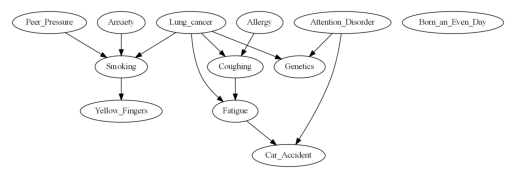

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.005 , inep_test = fisherz , uc_rule=  0


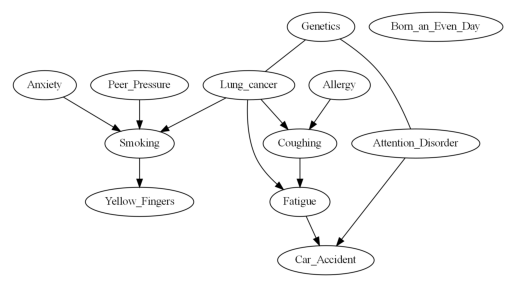

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.01 , inep_test = fisherz , uc_rule=  0


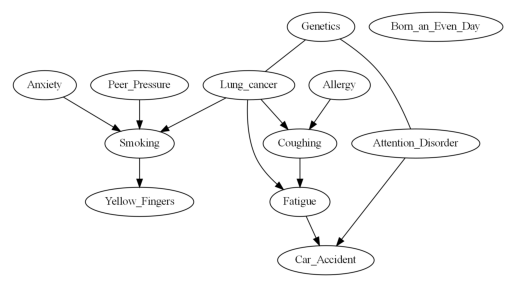

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.05 , inep_test = fisherz , uc_rule=  0


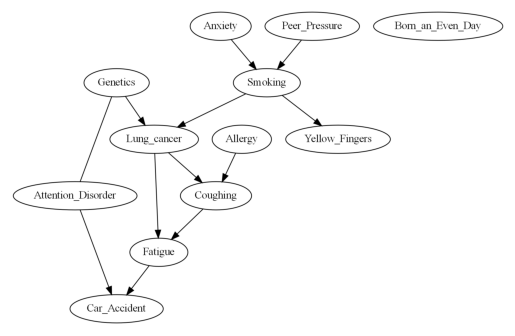

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.1 , inep_test = fisherz , uc_rule=  0


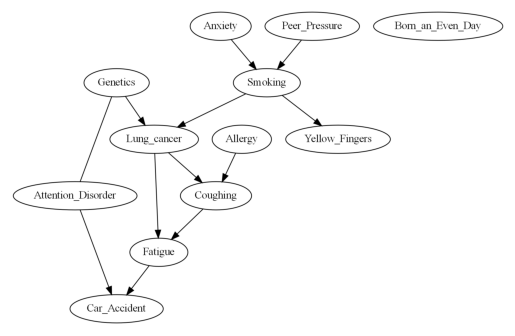

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 0.5 , inep_test = fisherz , uc_rule=  0


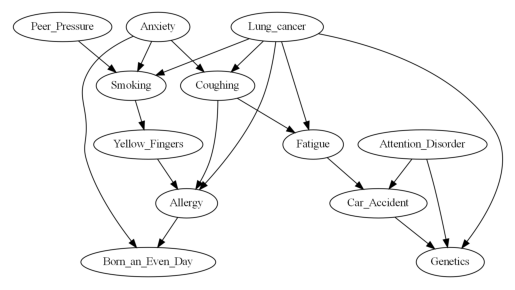

In [ ]:
#lists of hyperparameters to use in testing
rule=0
test="fisherz"
alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
tests=["fisherz","chisq","gsq"]

# alphas are the more interesting, we interacting with the other hyperparameters
# one at a time but always check multiple alphas for all of them
for alph in alphas:

# other hyperparameter values have been commented

  #for rule in range(0,3):
  #for test in tests:
    # this function builds the causal graph based on the data and our hyperparameters
    cg = pc(data_np, alpha=alph,indep_test=test, uc_rule=rule, verbose=False)

    # we convert to pydot because that seems the most efficient way to plot the
    # graph in casuallearn
    pyd = GraphUtils.to_pydot(cg.G)

    # we change the names of the nodes so that the graph is readable
    for node in pyd.get_nodes():
        index = int(node.get_name())
        node.set_label(attributes[index])

    # we plot the graphs to look at them
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    print("alpha =", alph, ", inep_test =", test, ", uc_rule= ", rule)
    plt.axis('off')
    plt.imshow(img)
    plt.show()


### Best graph
Given my preferred graph we pick its parameter settings.

(an alpha of 0.1 actually generated the same graph)


  0%|          | 0/12 [00:00<?, ?it/s]

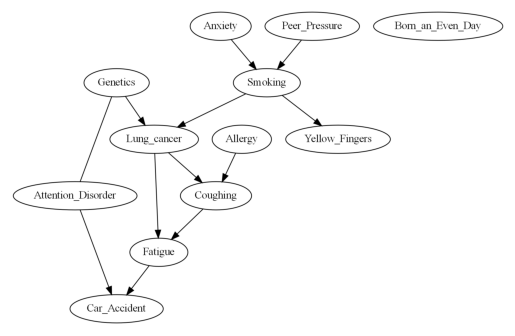

In [ ]:
# given my preferred graph we pick its parameter settings
cg = pc(data_np, alpha=0.05, uc_rule=0, verbose=False)

# this code is the same as the one in the previous cell
pyd = GraphUtils.to_pydot(cg.G)
for node in pyd.get_nodes():

    index = int(node.get_name())
    node.set_label(attributes[index])


tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()


### Orient undirected edges

We use the expert knowledge to orient the only unoriented edge
we can see that the graph is now oriented


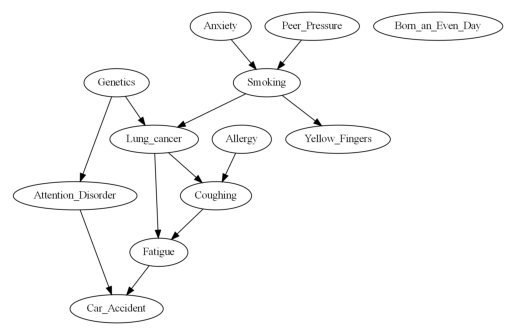

In [ ]:
# we add a directed edge between genetics and attention disorder
cg.G.add_directed_edge(cg.G.nodes [attributes.index("Genetics")],cg.G.nodes[attributes.index("Attention_Disorder")])


# we use the same code as before to add labels and plot
pyd = GraphUtils.to_pydot(cg.G)

for node in pyd.get_nodes():
    index = int(node.get_name())
    node.set_label(attributes[index])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# we can see that the graph is now oriented


## Parameter Fitting

Given the structure of the Causal Bayesian Network, you need to fit the parameters from data. Recall that in a Bayesian Network the parameters are stored in the Conditional Probability Tables that determine the probability of each variable given its parents in the graph. The goal is then to fill this table. As before, you can validate your results with the ground truth reported in the `LUCAS0` website. However, your implementation should **clearly show** that you fitted the parameters from data.

In [ ]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx
import pylab as plt

### pgmpy model
I have not found a way to turn a causallearn graph (or a pydot) into an nx
graph or a pgmpy network. I am confident there is a simple way to do that as this question seems to not been asked on the internet so far.

A very large part of the effort put into this project was trying to find out
what library is used as an intermediate language to move DAGs between
the other ones and while nx seems the most likely candidate such unification has (probably) not happened yet.

nx methods should be callable on pgmpy but that doesn't seem to be very
consistent. We still managed to build a graph and plot it to check whether there has been some error in moving the graph by hand.

born_an_even_day is not plotted because it has no edges but we did add it
to the model explicitely so there is no need to double check using the plot

['Smoking', 'Lung_cancer', 'Peer_Pressure', 'Yellow_Fingers', 'Genetics', 'Attention_Disorder', 'Car_Accident', 'Coughing', 'Fatigue', 'Anxiety', 'Allergy', 'Born_an_Even_Day']
[('Smoking', 'Lung_cancer'), ('Smoking', 'Yellow_Fingers'), ('Lung_cancer', 'Coughing'), ('Lung_cancer', 'Fatigue'), ('Peer_Pressure', 'Smoking'), ('Genetics', 'Lung_cancer'), ('Genetics', 'Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Coughing', 'Fatigue'), ('Fatigue', 'Car_Accident'), ('Anxiety', 'Smoking'), ('Allergy', 'Coughing')]


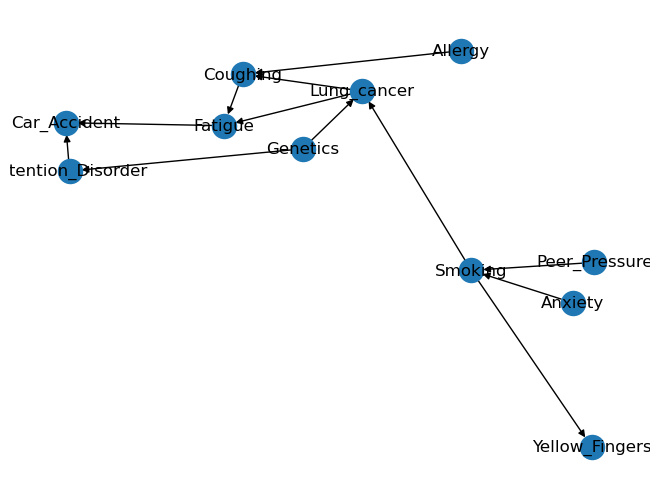

In [ ]:
# We manually copy all the edges from the previously discovered graph
edges = [
    ('Smoking', 'Lung_cancer'),
    ('Peer_Pressure', 'Smoking'),
    ('Smoking', 'Yellow_Fingers'),
    ('Genetics', 'Lung_cancer'),
    ('Genetics', 'Attention_Disorder'),
    ('Attention_Disorder', 'Car_Accident'),
    ('Lung_cancer', 'Coughing'),
    ('Lung_cancer', 'Fatigue'),
    ('Fatigue', 'Car_Accident'),
    ('Anxiety', 'Smoking'),
    ('Coughing', 'Fatigue'),
    ('Allergy', 'Coughing')
]

# We turn our edge list into a model
model = DiscreteBayesianNetwork (edges)
model.add_node('Born_an_Even_Day')

# We inspect the graph
print(list(model.nodes()))
print(list(model.edges()))

# We plot the graph
nx_graph = nx.DiGraph(model.edges())
nx.draw(nx_graph, with_labels=True)
plt.show()

### Compute cdps

In [ ]:
#given the model pgmpy is pretty straightforward in its computation of the cpds
model.fit(data)

# we print the cdps to compare them with the ground truth.
for cpd in model.get_cpds():
    print(f"CPD of {cpd.variable}:")
    print(cpd)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Smoking': 'N', 'Yellow_Fingers': 'N', 'Anxiety': 'N', 'Peer_Pressure': 'N', 'Genetics': 'N', 'Attention_Disorder': 'N', 'Born_an_Even_Day': 'N', 'Car_Accident': 'N', 'Fatigue': 'N', 'Allergy': 'N', 'Coughing': 'N', 'Lung_cancer': 'N'}


CPD of Smoking:
+---------------+-------------------+--------------------+---------------------+---------------------+
| Anxiety       | Anxiety(0)        | Anxiety(0)         | Anxiety(1)          | Anxiety(1)          |
+---------------+-------------------+--------------------+---------------------+---------------------+
| Peer_Pressure | Peer_Pressure(0)  | Peer_Pressure(1)   | Peer_Pressure(0)    | Peer_Pressure(1)    |
+---------------+-------------------+--------------------+---------------------+---------------------+
| Smoking(0)    | 0.569672131147541 | 0.2868525896414343 | 0.13148371531966224 | 0.08333333333333333 |
+---------------+-------------------+--------------------+---------------------+---------------------+
| Smoking(1)    | 0.430327868852459 | 0.7131474103585658 | 0.8685162846803377  | 0.9166666666666666  |
+---------------+-------------------+--------------------+---------------------+---------------------+
CPD of Lung_cancer:
+----------------+-------------------


####Table with the cdps taken from LUCAS against the ones we found out.
The largest difference (0.07545) is in P(Fatigue=T|Lung cancer=F, Coughing=T)
that is pretty big, but the other ones don't go above 0.03.
The results overall seem satisfying

P(Anxiety=T)=0.64277	                              0.6305

P(Peer Pressure=T)=0.32997	                      	0.3415

P(Smoking=T|Peer Pressure=F, Anxiety=F)=0.43118		  0.430327868852459

P(Smoking=T|Peer Pressure=T, Anxiety=F)=0.74591		  0.7131474103585658

P(Smoking=T|Peer Pressure=F, Anxiety=T)=0.8686		  0.8685162846803377

P(Smoking=T|Peer Pressure=T, Anxiety=T)=0.91576		  0.9166666666666666


P(Yellow Fingers=T|Smoking=F)=0.23119               0.22424242424242424

P(Yellow Fingers=T|Smoking=T)=0.95372               0.9654485049833887

P(Genetics=T)=0.15953                               0.1395

P(Lung cancer=T|Genetics=F, Smoking=F)=0.23146			0.2517482517482518

P(Lung cancer=T|Genetics=T, Smoking=F)=0.86996			0.8939393939393939

P(Lung cancer=T|Genetics=F, Smoking=T)=0.83934			0.8227554179566563

P(Lung cancer=T|Genetics=T, Smoking=T)=0.99351		  1.0

P(Attention Disorder=T|Genetics=F)=0.28956		      0.27193492155723414

P(Attention Disorder=T|Genetics=T)=0.68706		      0.6344086021505376

P(Born an Even Day=T)=0.5			                      0.4895

P(Allergy=T)=0.32841			                          0.343

P(Coughing=T|Allergy=F, Lung cancer=F)=0.1347		    0.1352112676056338

P(Coughing=T|Allergy=T, Lung cancer=F)=0.64592		  0.6435643564356436

P(Coughing=T|Allergy=F, Lung cancer=T)=0.7664		    0.7705943691345151

P(Coughing=T|Allergy=T, Lung cancer=T)=0.99947			1.0

P(Fatigue=T|Lung cancer=F, Coughing=F)=0.35212		  0.35883905013192613

P(Fatigue=T|Lung cancer=T, Coughing=F)=0.56514		  0.5454545454545454

P(Fatigue=T|Lung cancer=F, Coughing=T)=0.80016		  0.7247191011235955

P(Fatigue=T|Lung cancer=T, Coughing=T)=0.89589		  0.8904333605887162

P(Car Accident=T|Attention Disorder=F, Fatigue=F)=0.2274		  0.21351351351351353

P(Car Accident=T|Attention Disorder=T, Fatigue=F)=0.779		    0.7628205128205128

P(Car Accident=T|Attention Disorder=F, Fatigue=T)=0.78861			0.7857868020304568

P(Car Accident=T|Attention Disorder=T, Fatigue=T)=0.97169		  0.9693251533742331


## Conditional and Interventional Estimate

What is a valid adjustment set to estimate the causal effect of `Lung_cancer` on `Car Accident`? Justify your choice and compute the Average Treatment Effect. Then, compute the difference between conditional expectations and discuss whether they agree or not.

In [ ]:
from dowhy import CausalModel

The adjustment set is composed only by the node Genetics, as it is the only parent of X that allows for a path to Y which doesn't include X (that is, the one through attention_disorder)

### Car Accident conditioned only on Lung cancer
We compute the difference between the average value of car accident given lung cancer and given no lung cancer and check the difference between those values

$E[\text{CarAccident} \mid \text{LungCancer = 1}]-E[\text{CarAccident} \mid \text{LungCancer = 0}]$

In [ ]:
# Compute the conditional means
mean_Y_given_X1 = data.loc[data['Lung_cancer'] == 1, 'Car_Accident'].mean()
mean_Y_given_X0 = data.loc[data['Lung_cancer'] == 0, 'Car_Accident'].mean()

# Compute the difference between the two
conditional_diff = mean_Y_given_X1 - mean_Y_given_X0
print(mean_Y_given_X1)
print(mean_Y_given_X0)
print(conditional_diff)

0.7699237699237699
0.6014362657091562
0.16848750421461367


### ATE computation using Genetics
We compute

$\sum_{w \in \{0,1\}} E[\text{CarAccident} \mid \text{LungCancer = 1}, \text{Genetics}=w] \cdot P(\text{Genetics}=w)$

and

$\sum_{w \in \{0,1\}} E[\text{CarAccident} \mid \text{LungCancer = 0}, \text{Genetics}=w] \cdot P(\text{Genetics}=w)$

Using the values from the dataset: the difference between them is the average treatment effect, adjusted for genetics

In [ ]:
# We compute a matrix of lung cancer and genetics 0s and 1s and count how many points
# have car accident = 1 in each square of the matrix
X1_G1 = data.loc[(data['Lung_cancer'] == 1) & (data['Genetics'] == 1), 'Car_Accident'].mean()
X1_G0 = data.loc[(data['Lung_cancer'] == 1) & (data['Genetics'] == 0), 'Car_Accident'].mean()
X0_G1 = data.loc[(data['Lung_cancer'] == 0) & (data['Genetics'] == 1), 'Car_Accident'].mean()
X0_G0 = data.loc[(data['Lung_cancer'] == 0) & (data['Genetics'] == 0), 'Car_Accident'].mean()

# We compute the marginal distribution of Genetics
P_G1 = (data['Genetics'] == 1).mean()
P_G0 = 1 - P_G1

# We adjust expectations according to the distribution of Genetics
Y_do_X1 = X1_G1 * P_G1 + X1_G0 * P_G0
Y_do_X0 = X0_G1 * P_G1 + X0_G0 * P_G0

# We compute the difference between the points where
adjusted_ate = Y_do_X1 - Y_do_X0
print(Y_do_X1)
print(Y_do_X0)
print(adjusted_ate)

0.7624697075777365
0.5975788311688313
0.1648908764089052



The result we just got from our ATE computation is extremely close to the one we had gotten without conditioning on genetics

This implies that Genetics is not actually a good adjustment set (or that there is very little effect to adjust for), as we had hypothized

In [ ]:
# we count in absolute terms the relationships between genetics and lung cancer
print(len(data.loc[(data['Genetics'] == 1) & (data['Lung_cancer'] == 0)]))
print(len(data.loc[(data['Genetics'] == 1) & (data['Lung_cancer'] == 1)]))
print(len(data.loc[(data['Genetics'] == 0) & (data['Lung_cancer'] == 1)]))
print(len(data.loc[(data['Genetics'] == 0) & (data['Lung_cancer'] == 0)]))


7
272
1171
550


It seems that the vast majority of values in which Genetics is 1 also have lung cancer equal to 1. This might not be the best sign of a good adjustment set.
Since attention disorder also blocks the backdoor path (as it is the only other child of genetics), let's try exploring it too

In [ ]:
# we count in absolute terms the relationships between lung cancer and attention disorder
print(len(data.loc[(data['Attention_Disorder'] == 1) & (data['Lung_cancer'] == 0)]))
print(len(data.loc[(data['Attention_Disorder'] == 1) & (data['Lung_cancer'] == 1)]))
print(len(data.loc[(data['Attention_Disorder'] == 0) & (data['Lung_cancer'] == 1)]))
print(len(data.loc[(data['Attention_Disorder'] == 0) & (data['Lung_cancer'] == 0)]))

151
494
949
406


### ATE using attention disorder
Attention disorder seems to not share the same problem as genetics. Let's try running the same code as before using it as our adjustment set

In [ ]:
# We compute a matrix of lung cancer and attention disorder 0s and 1s and count how many points
# have car accident = 1 in each square of the matrix
X1_A1 = data.loc[(data['Lung_cancer'] == 1) & (data['Attention_Disorder'] == 1), 'Car_Accident'].mean()
X1_A0 = data.loc[(data['Lung_cancer'] == 1) & (data['Attention_Disorder'] == 0), 'Car_Accident'].mean()
X0_A1 = data.loc[(data['Lung_cancer'] == 0) & (data['Attention_Disorder'] == 1), 'Car_Accident'].mean()
X0_A0 = data.loc[(data['Lung_cancer'] == 0) & (data['Attention_Disorder'] == 0), 'Car_Accident'].mean()

# We compute the marginal distribution of attention disorder
P_A1 = (data['Attention_Disorder'] == 1).mean()
P_A0 = 1 - P_G1

# We adjust expectations according to the distribution of attention disorder
Y_do_X1 = X1_A1 * P_A1 + X1_A0 * P_A0
Y_do_X0 = X0_A1 * P_A1 + X0_A0 * P_A0

# We compute the difference between the points where
adjusted_ate = Y_do_X1 - Y_do_X0
print(Y_do_X1)
print(Y_do_X0)
print(adjusted_ate)

0.7645700460318341
0.6174012331582553
0.14716881287357875


The effect now is slightly lower than the one we had previously estimated using genetics. It is still very similar to the naive one but not uncanningly so

### ATE estimation using dowhy

 dowhy has its own ate function, so we try it to compare its results with ours
 we first need to build the model. For some reason i'm unable to utilize the
 one i had originally built during the structure learning (from my understanding casuallearn is part of pywhy) but luckily CausalModel accepts nx graphs as input

 Printing the result confirms us that genetics was indeed the adjustment_set
 frontdoor is another method that is explained in the book that requires
 a different adjustment set from the one we use in backdoor



In [ ]:
# we build the dowhy causalmodel using our graph and data
modeldw = CausalModel(
    data=data,
    treatment='Lung_cancer',
    outcome='Car_Accident',
    graph=nx_graph
)

# i don't really understand why but the estimate is a required input in
# the estimate_effect method, which we will use later.
# running this function also helps us confirm our adjustment sets
estimand = modeldw.identify_effect()

# we print this
print(estimand)


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Lung_cancer'] on outcome ['Car_Accident']
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Smoking']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:['Fatigue', 'Coughing']
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                           
──────────────(E[Car_Accident|Attention_Disorder])
d[Lung_cancer]                                    
Estimand assumption 1, Unconfoundedness: If U→{Lung_cancer} and U→Car_Accident then P(Car_Accident|Lung_cancer,Attention_Disorder,U) = P(Car_Accident|Lung_cancer,Attention_Disorder)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                    -1⎤
 ⎢    d                    ⎛    d                    ⎞  ⎥
E⎢──────────(Car_Accident)⋅⎜──────────([Lung_cancer])⎟  ⎥
 ⎣d[Smoking]               ⎝d[Smoking]               ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Car_Accident then ¬(U →→{Smoking})
Estimand assumption 2, Exclusion: If we remove {Smoking}→{Lung_cancer}, then ¬({Smoking}→Car_Accident)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡         d          


 We try both the backdoor and frontdoor methods as they are already implemented in dowhy


In [ ]:
# we run the estimation function using genetics, as suggested by the estimand
estimatebackgen = modeldw.estimate_effect(
    estimand,
    method_name="backdoor.linear_regression",
    method_params={"backdoor_adjustment_set": ["Genetics"]}
)

# we also run using attention disorder, as it had given us more promising results
estimatebackad = modeldw.estimate_effect(
    estimand,
    method_name="backdoor.linear_regression",
    method_params={"backdoor_adjustment_set": ["Attention_Disorder"]}
)

# we run the frontdoor effect estimation function using the values we obtained
# from identify_effect
estimatefront = modeldw.estimate_effect(
    estimand,
    method_name="frontdoor.linear_regression",
    method_params={"frontdoor_adjustment_set": ["Coughing",  "Fatigue"]}
)

# we print the results
print(estimatebackgen.value, '\n', estimatebackad.value, '\n', estimatefront.value)

INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Car_Accident~Lung_cancer+Attention_Disorder+Lung_cancer*Allergy+Lung_cancer*Attention_Disorder
INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Car_Accident~Lung_cancer+Attention_Disorder+Lung_cancer*Allergy+Lung_cancer*Attention_Disorder
INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Car_Accident~Lung_cancer+Attention_Disorder+Lung_cancer*Allergy+Lung_cancer*Attention_Disorder


0.14725341493995192 
 0.14725341493995192 
 0.14725341493995192


All functions give us the same result.
In the backdoor method the algorithm is probably able to use whatever set completely blocks the path, which makes this result easily predictable, while in the frontdoor method it is more interesting to see it get the same results.

All results are also generally much closer to the one we had found using attention disorder as our adjustment set.


### Conclusions
Despite my initial enthusiasm genetics proved itself not to be the correct adjustment set. The fact that the edge between it and attention disorder had to be manually directed only prompted me to think that there is a weak causal relationship between genetics and attention disorder, which in my eyes explained the weak effect genetics had as an adjustment set. Had i been more open minded i would have lost much less time exploring libraries.

 Regarding the slight difference between dowhy's and my estimations, given that we use the same data and refer to the same function in our computation, there must be something something i don't expect to be happening in the linear regression method of dowhy (looking at the linear_regression_estimator function, which is called in dowhy/causal_model it is unclear what the library does with this linear estimator but given the nature of the problem there are not many guesses). This is a problem i explored too deeply before trying out attention disorder as an adjustment set, but it might still be somewhat interesting to note.
